<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/ssrVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised VAE for data with orientational disorder


---

This notebook demonstrates how to use a variational autoencoder (VAE) to generalize from a small subset of labeled data with the weak orientational disorder to a large unlabelled data set with a much stronger orientational disorder.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [ ]:
#@title Installations
!pip install -q pyroved kornia

In [ ]:
#@title Imports
import pyroved as pv

import kornia as K
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

tt = torch.tensor

In [4]:
#@title Helper function
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1), pv.utils.to_onehot(labels_all.long(), n=4)


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

## Training data

We are going to make our own training data from playing card suits, with monochrome clubs, spades, diamonds, and hearts.  Using a digitized symbols from Word as a starting point, we apply a set of affine transforms including rotation, shear, translation, and scale to prepare our data sets. Note that we are going to apply different sets of distortions to labeled and unlabeled parts of our data.

In [5]:
cards = get_data()

In [ ]:
# Labeled set (no transaltion, small rotations)
X_sup, y_sup = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=5, translation=None, 
    samples=200, seed=0)
# Unlabeled set (translation, large rotations)
X_unsup, _ = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=3000, seed=1)
# Validation set (same as unlabeled, but using different seed)
X_val, y_val = transform_images(
    *cards,
    shear=15, scale=(1, 1.3), angle=60, translation=0.1, 
    samples=1000, seed=2)

Here's the supervised part of our training set:

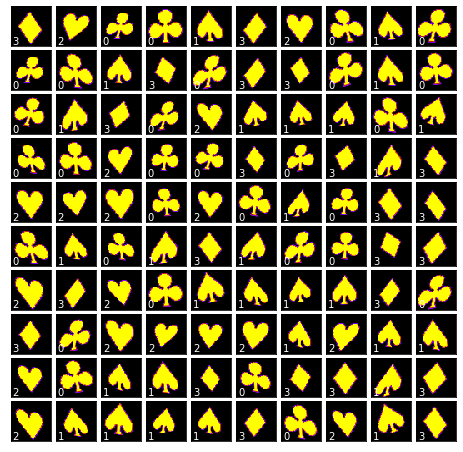

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_sup), size=(1,))
    im = X_sup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_sup[i].argmax().item()),
            transform=ax.transAxes, color='white')

... and this is the unsupervised one. Note that here we have much larger orientational disorder as long as random offsets (in other words, the rotations and translations of the unlabeled data come from a different distribution than those of the labeled data!)

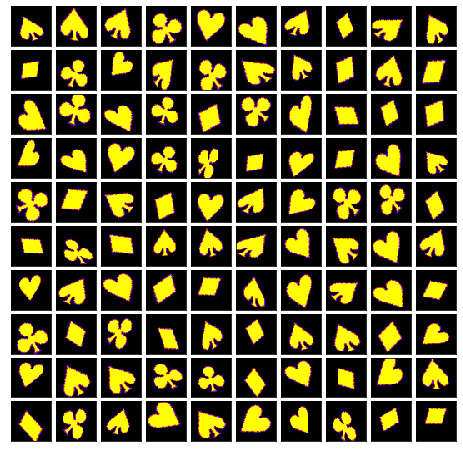

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_unsup), size=(1,))
    im = X_unsup[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

Next, we create dataloaders:

In [9]:
(loader_unsup, loader_sup,
 loader_val) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_val, y_val), batch_size=64)

In [10]:
r = len(loader_sup) / (len(loader_unsup) + len(loader_sup))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.06467661691542288


## Train ss-iVAE model

Finally, we will train a **s**emi-**s**upervised **VAE** model that enforces the **i**nvariance to rotations and translations. The goal is to use a limited amount (~6%) of labeled data with small orientational (and no positional) disorder to categorize large volumes of unlabeled data characterized by a (much) higher orientational (and some positional) disorder.

Epoch: 1 Training loss: 800.4837, Test accuracy: 0.3947
Epoch: 2 Training loss: 507.9027, Test accuracy: 0.4945
Epoch: 3 Training loss: 456.1990, Test accuracy: 0.4983
Epoch: 4 Training loss: 413.7601, Test accuracy: 0.5505
Epoch: 5 Training loss: 386.3092, Test accuracy: 0.5737
Epoch: 6 Training loss: 369.0811, Test accuracy: 0.5677
Epoch: 7 Training loss: 355.9949, Test accuracy: 0.5660
Epoch: 8 Training loss: 345.1159, Test accuracy: 0.5735
Epoch: 9 Training loss: 333.1460, Test accuracy: 0.5743
Epoch: 10 Training loss: 321.0861, Test accuracy: 0.5933


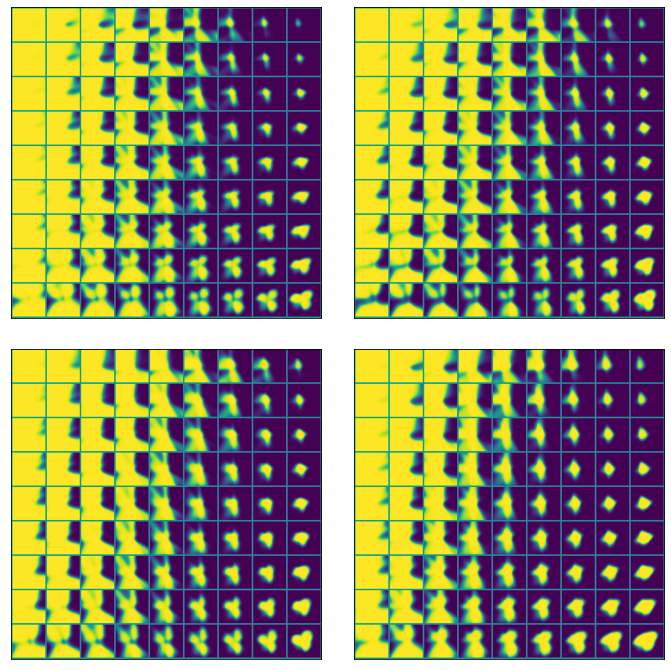

Epoch: 11 Training loss: 312.6869, Test accuracy: 0.6148
Epoch: 12 Training loss: 303.6099, Test accuracy: 0.6335
Epoch: 13 Training loss: 294.8701, Test accuracy: 0.6202
Epoch: 14 Training loss: 287.0479, Test accuracy: 0.6645
Epoch: 15 Training loss: 281.2659, Test accuracy: 0.7100
Epoch: 16 Training loss: 275.4934, Test accuracy: 0.7342
Epoch: 17 Training loss: 267.5125, Test accuracy: 0.7500
Epoch: 18 Training loss: 264.5259, Test accuracy: 0.7640
Epoch: 19 Training loss: 259.8031, Test accuracy: 0.7688
Epoch: 20 Training loss: 256.8533, Test accuracy: 0.7867


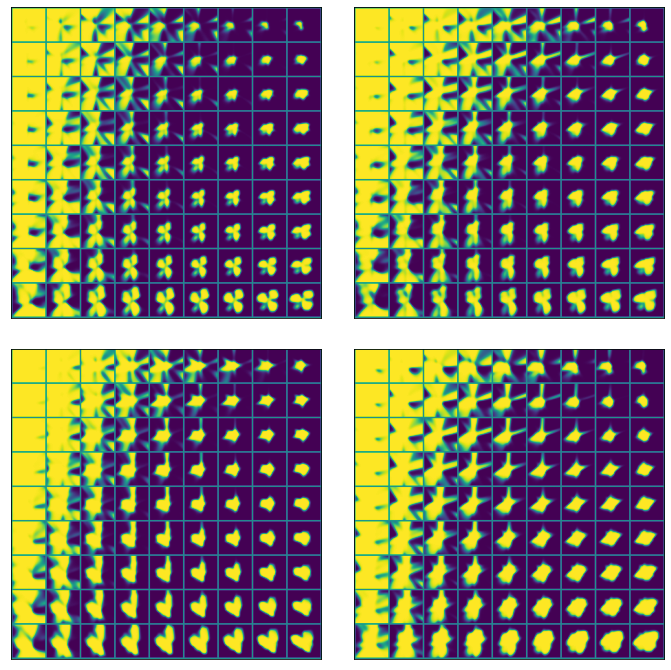

Epoch: 21 Training loss: 251.9897, Test accuracy: 0.7900
Epoch: 22 Training loss: 251.2543, Test accuracy: 0.7738
Epoch: 23 Training loss: 245.3799, Test accuracy: 0.7960
Epoch: 24 Training loss: 242.8722, Test accuracy: 0.8033
Epoch: 25 Training loss: 243.1617, Test accuracy: 0.8017
Epoch: 26 Training loss: 240.3846, Test accuracy: 0.8013
Epoch: 27 Training loss: 238.2004, Test accuracy: 0.8170
Epoch: 28 Training loss: 236.6340, Test accuracy: 0.8173
Epoch: 29 Training loss: 236.0424, Test accuracy: 0.8217
Epoch: 30 Training loss: 234.8954, Test accuracy: 0.8285


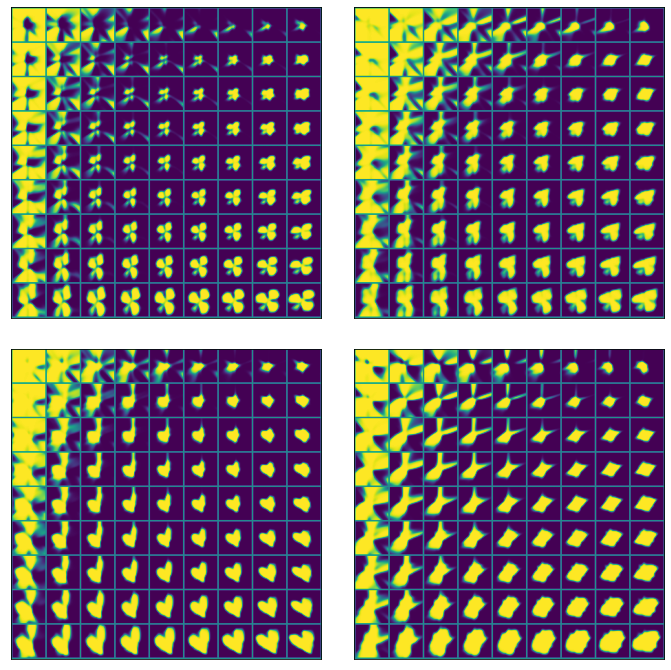

Epoch: 31 Training loss: 232.5463, Test accuracy: 0.8167
Epoch: 32 Training loss: 227.4995, Test accuracy: 0.8273
Epoch: 33 Training loss: 227.6731, Test accuracy: 0.8315
Epoch: 34 Training loss: 224.6284, Test accuracy: 0.8345
Epoch: 35 Training loss: 226.9342, Test accuracy: 0.8305
Epoch: 36 Training loss: 221.6192, Test accuracy: 0.8380
Epoch: 37 Training loss: 217.9111, Test accuracy: 0.8558
Epoch: 38 Training loss: 218.6043, Test accuracy: 0.8290
Epoch: 39 Training loss: 218.5179, Test accuracy: 0.8582
Epoch: 40 Training loss: 216.8258, Test accuracy: 0.8558


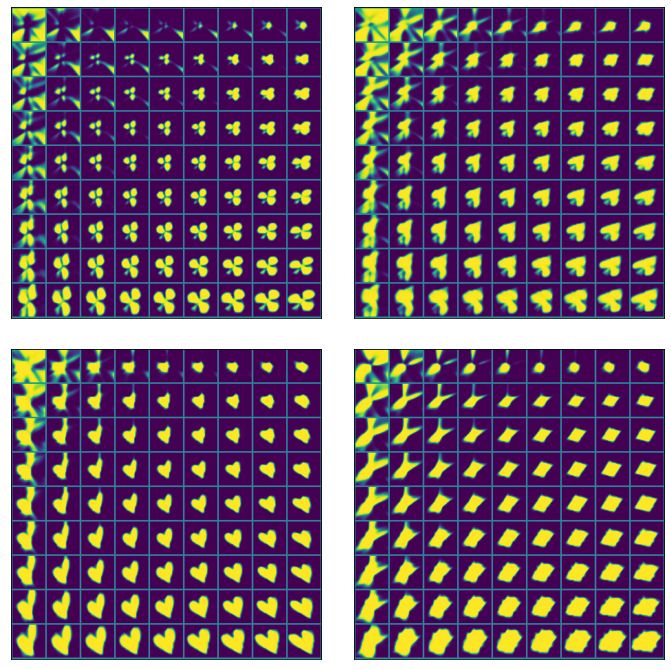

Epoch: 41 Training loss: 214.0852, Test accuracy: 0.8558
Epoch: 42 Training loss: 214.1398, Test accuracy: 0.8570
Epoch: 43 Training loss: 211.2131, Test accuracy: 0.8632
Epoch: 44 Training loss: 209.3538, Test accuracy: 0.8568
Epoch: 45 Training loss: 212.2212, Test accuracy: 0.8560
Epoch: 46 Training loss: 209.3917, Test accuracy: 0.8562
Epoch: 47 Training loss: 207.3116, Test accuracy: 0.8650
Epoch: 48 Training loss: 206.5801, Test accuracy: 0.8642
Epoch: 49 Training loss: 206.3128, Test accuracy: 0.8655
Epoch: 50 Training loss: 204.9032, Test accuracy: 0.8622


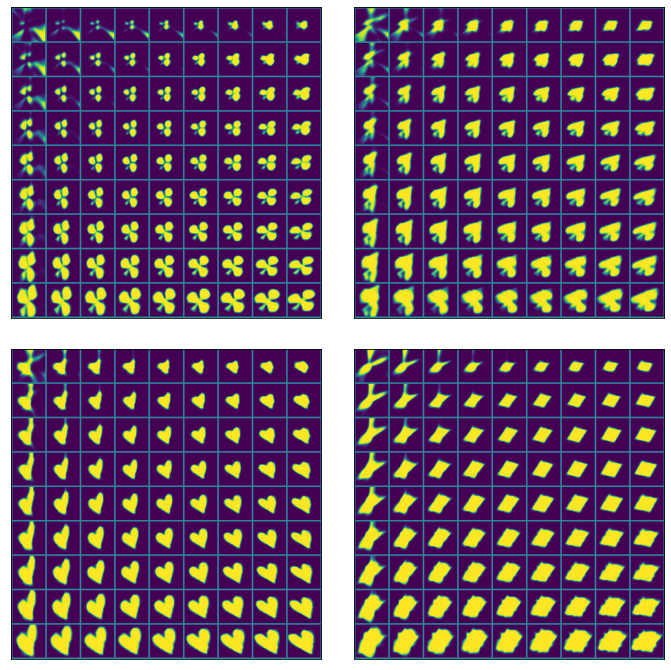

Epoch: 51 Training loss: 202.4397, Test accuracy: 0.8610
Epoch: 52 Training loss: 202.9570, Test accuracy: 0.8682
Epoch: 53 Training loss: 206.1181, Test accuracy: 0.8618
Epoch: 54 Training loss: 201.5049, Test accuracy: 0.8645
Epoch: 55 Training loss: 198.8394, Test accuracy: 0.8500
Epoch: 56 Training loss: 198.7807, Test accuracy: 0.8675
Epoch: 57 Training loss: 196.7273, Test accuracy: 0.8525
Epoch: 58 Training loss: 196.2943, Test accuracy: 0.8525
Epoch: 59 Training loss: 195.9977, Test accuracy: 0.8680
Epoch: 60 Training loss: 195.6121, Test accuracy: 0.8648


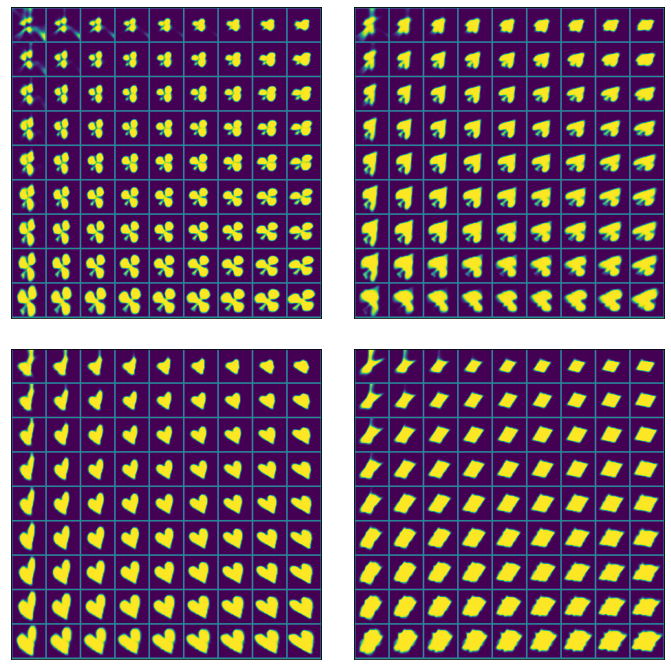

Epoch: 61 Training loss: 194.1183, Test accuracy: 0.8652
Epoch: 62 Training loss: 192.4668, Test accuracy: 0.8695
Epoch: 63 Training loss: 191.1664, Test accuracy: 0.8668
Epoch: 64 Training loss: 192.9609, Test accuracy: 0.8670
Epoch: 65 Training loss: 190.9281, Test accuracy: 0.8652
Epoch: 66 Training loss: 188.8781, Test accuracy: 0.8678
Epoch: 67 Training loss: 188.1810, Test accuracy: 0.8670
Epoch: 68 Training loss: 187.3356, Test accuracy: 0.8762
Epoch: 69 Training loss: 187.0325, Test accuracy: 0.8660
Epoch: 70 Training loss: 182.6354, Test accuracy: 0.8612


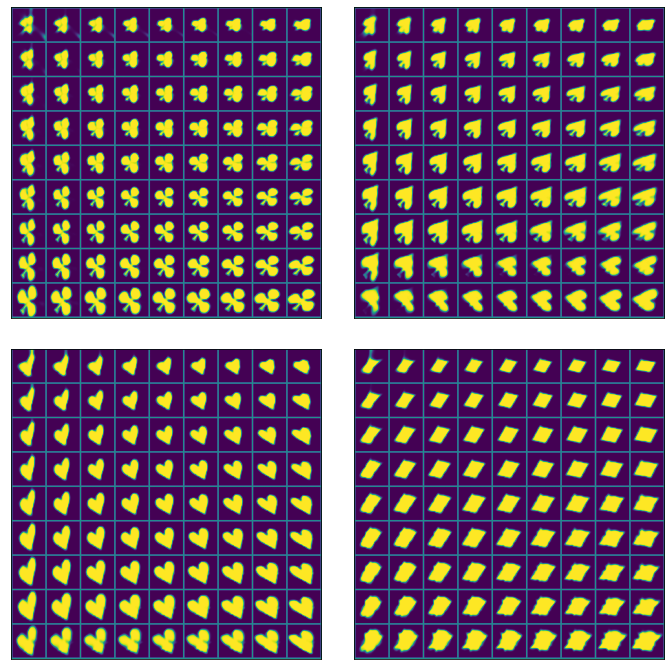

Epoch: 71 Training loss: 182.0018, Test accuracy: 0.8672
Epoch: 72 Training loss: 179.7792, Test accuracy: 0.8712
Epoch: 73 Training loss: 180.4201, Test accuracy: 0.8698
Epoch: 74 Training loss: 182.7852, Test accuracy: 0.8688
Epoch: 75 Training loss: 177.9133, Test accuracy: 0.8610
Epoch: 76 Training loss: 176.1273, Test accuracy: 0.8692
Epoch: 77 Training loss: 180.2130, Test accuracy: 0.8625
Epoch: 78 Training loss: 175.8645, Test accuracy: 0.8735
Epoch: 79 Training loss: 174.4560, Test accuracy: 0.8700
Epoch: 80 Training loss: 174.6329, Test accuracy: 0.8690


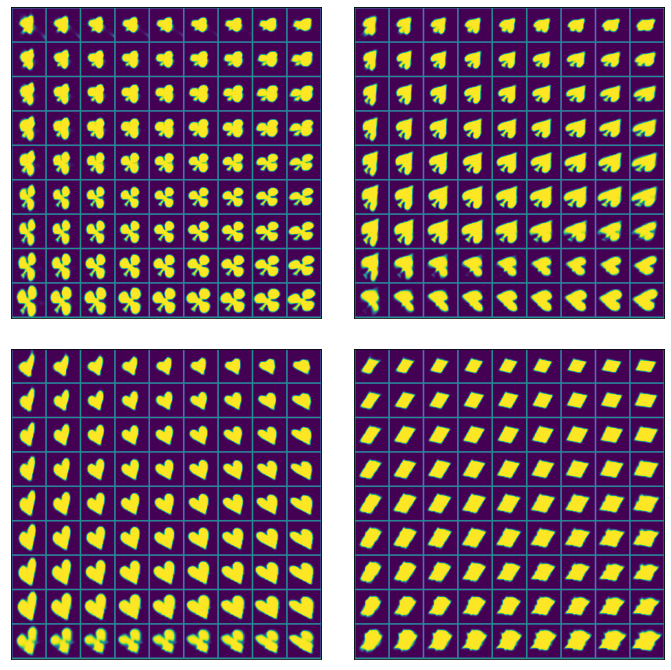

Epoch: 81 Training loss: 172.8308, Test accuracy: 0.8735
Epoch: 82 Training loss: 175.7765, Test accuracy: 0.8645
Epoch: 83 Training loss: 172.2640, Test accuracy: 0.8715
Epoch: 84 Training loss: 171.1834, Test accuracy: 0.8685
Epoch: 85 Training loss: 170.0845, Test accuracy: 0.8695
Epoch: 86 Training loss: 171.8750, Test accuracy: 0.8670
Epoch: 87 Training loss: 174.1630, Test accuracy: 0.8715
Epoch: 88 Training loss: 171.7017, Test accuracy: 0.8742
Epoch: 89 Training loss: 169.8616, Test accuracy: 0.8662
Epoch: 90 Training loss: 168.0674, Test accuracy: 0.8738


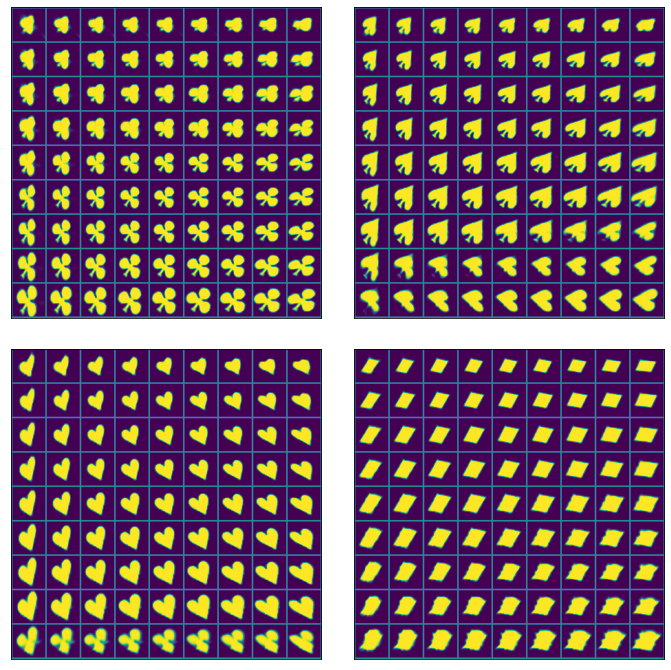

Epoch: 91 Training loss: 167.4541, Test accuracy: 0.8708
Epoch: 92 Training loss: 168.0933, Test accuracy: 0.8735
Epoch: 93 Training loss: 173.5018, Test accuracy: 0.8778
Epoch: 94 Training loss: 168.4087, Test accuracy: 0.8682
Epoch: 95 Training loss: 168.0026, Test accuracy: 0.8745
Epoch: 96 Training loss: 166.9977, Test accuracy: 0.8705
Epoch: 97 Training loss: 167.1427, Test accuracy: 0.8690
Epoch: 98 Training loss: 168.8069, Test accuracy: 0.8652
Epoch: 99 Training loss: 173.8811, Test accuracy: 0.8675
Epoch: 100 Training loss: 165.2897, Test accuracy: 0.8732


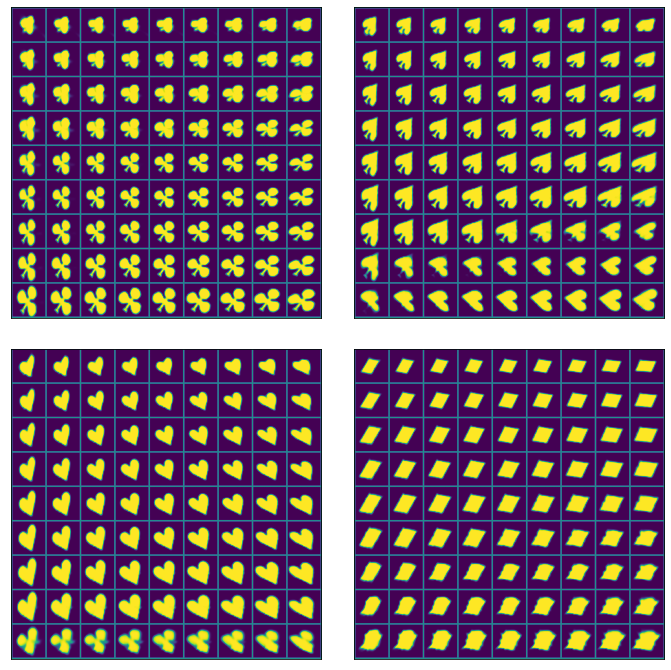

In [12]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 

# Initialize model
ssvae = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r', 't'])

# Initialize trainer
trainer = pv.trainers.auxSVItrainer(ssvae)

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(100):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(loader_unsup, loader_sup, loader_val,
                 aux_loss_multiplier=50, scale_factor=sc)
    trainer.print_statistics()
    # Plot learned latent manifolds every 10 epoch
    if (e+1) % 10 == 0:
        plot_manifolds(ssvae)

Looks like we achieved ~88% accuracy with only ~6% of the data labeled! Furthermore, we were able to disentangle two main factors of data variation (beyond rotations and translations), namely, scale and shear deformation, which are encoded in the first (top to bottom) and second (left to right) latent variables. 

We can also plot traversals of the learned manifold where the horizontal direction corresponds to one of the continuous latent variables (while the other one is fixed at 0) and the vertical direction corresponds to the categorical variable:

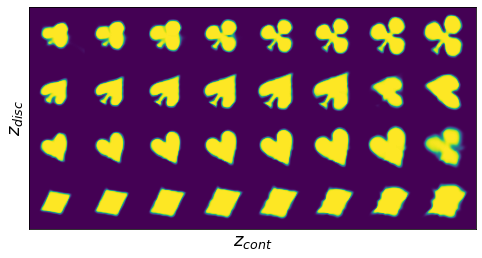

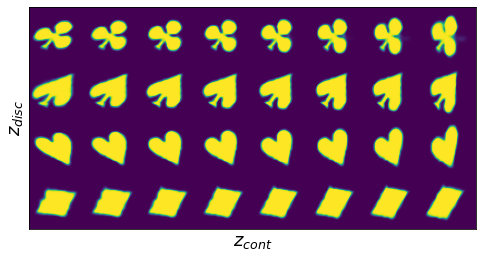

In [13]:
for i in range(2):
    ssvae.manifold_traversal(8, i, cmap='viridis')